# ANÁLISIS DE LA TERCERA EVALUACIÓN
## IES Puerto de la Cruz - Telesforo Bravo | Curso 2017-2018

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML
import os

## CARGA DE DATOS

In [2]:
YEAR, EVALUATION = 2017, 3

In [3]:
df = pd.DataFrame()
labels = []
for y in range(YEAR - 2, YEAR + 1):
    year_label = "C" + str(y)[2:] + str(y + 1)[2:]
    path = os.path.join("../data", year_label + ".xlsx")
    if y == YEAR:
        num_evaluations = EVALUATION
    else:
        num_evaluations = 3
    for ev in range(1, num_evaluations + 1):
        evaluation_label = f"E{ev}"
        data = pd.read_excel(path, sheet_name=evaluation_label)
        data["curso"] = year_label
        data["evaluación"] = evaluation_label
        data["absentismo"] = data["absentismo_justificado"] + data["absentismo_injustificado"]
        data["éxito_abs"] = round(data["ratio"] * (data["éxito"] / 100))
        data.set_index(["curso", "evaluación", "grupo"], inplace=True)
        df = df.append(data)
        labels.append((year_label, evaluation_label))
df.fillna(0, inplace=True)

In [4]:
df.head()

etapa  éxito  absentismo_justificado  \
curso evaluación grupo                                        
C1516 E1         ESO1A   ESO   23.1                    1.51   
                 ESO1B   ESO   26.9                    2.70   
                 ESO1C   ESO   26.9                    1.00   
                 ESO2A   ESO   40.0                    0.72   
                 ESO2B   ESO   34.8                    1.58   

                        absentismo_injustificado  partes  \
curso evaluación grupo                                     
C1516 E1         ESO1A                      2.40     1.0   
                 ESO1B                      4.59     0.0   
                 ESO1C                      3.64     1.0   
                 ESO2A                      1.30     1.0   
                 ESO2B                      4.52     0.0   

                        suspensión_asistencia  ratio  absentismo  éxito_abs  
curso evaluación grupo                                                       
C1516 E1         ESO1A                    0.0   26.0        3.91        6.0  
                 ESO1B                    0.0   26.0        7.29        7.0  
                 ESO1C                    0.0   26.0        4.64        7.0  
                 ESO2A                    0.0   20.0        2.02        8.0  
                 ESO2B                    0.0   23.0        6.10        8.0

In [5]:
# dataframe for current year and evaluation
dfc = df.loc[labels[-1]]

In [6]:
# dataframe for comparisons with last evaluation
df_comp = dfc.merge(df.loc[labels[-2]], left_index=True, right_index=True)

In [7]:
def get_data_by_stages(df, stages):
    if not isinstance(stages, list):
        stages = [stages]
    return df[df["etapa"].isin(stages)]

In [66]:
def makeup_chart(fontsize, value_margin, is_percentage, show_integer):
    if is_percentage:
        percentage_symbol = "%"
    else:
        percentage_symbol = ""
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(fontsize=fontsize)
    ax = plt.gca()
    if show_integer:
        annotation = "{:.0f}{}"
    else:
        annotation = "{:.2f}{}"
    # show values in bars
    for p in ax.patches:
        ax.annotate(
            annotation.format(p.get_height(), percentage_symbol),
            (p.get_x() + p.get_width() / 2., p.get_height() - value_margin),
            ha="center", va="center", fontsize=fontsize, color="white"
        )
    # hide chart frame
    for spine in ax.spines.values():
        spine.set_visible(False)
    # hide ticks
    plt.tick_params(top="off", bottom="off", left="off",
                    right="off", labelleft="off", labelbottom="on")

In [9]:
def bar_chart(serie, is_percentage=True, show_integer=True):
    FONTSIZE = 25
    serie = serie.sort_values()
    #plt.figure(figsize=(30, 10), dpi=96)
    plt.figure(figsize=(30, 10))
    sns.barplot(serie.index, serie)
    makeup_chart(FONTSIZE, serie.max() / 20, is_percentage, show_integer)

In [10]:
def factor_chart(data, y, value_margin=2, is_percentage=True, estimator=np.mean, show_integer=True):
    FONTSIZE = 14
    plt.figure(figsize=(30, 10))
    colors = ["orange red", "windows blue", "amber"]
    custom_palette = sns.xkcd_palette(colors)
    sns.factorplot(x="etapa", y=y, hue="curso", size=7, aspect=2, legend=False,
                   estimator=estimator, data=data.reset_index(), kind="bar",
                   palette=custom_palette, ci=None)
    plt.legend(loc="best", prop={"size": FONTSIZE}, frameon=True, framealpha=0.9)
    makeup_chart(FONTSIZE, value_margin, is_percentage, show_integer)

In [11]:
def color_gradient(serie, palette_name, inverse=False):
    unique_values = np.sort(serie.unique())
    if inverse:
        unique_values = unique_values[::-1]
    pal = sns.color_palette(palette_name, unique_values.size)
    cmap = {v: c for v, c in zip(unique_values, pal)}
    return np.array(serie.map(lambda x: cmap[x]))

In [12]:
CONFIG = (
    {"color": "Greens", "verb": "mejorado"},
    {"color": "Reds_r", "verb": "empeorado"}
)

def delta_chart(*args, label, inverse=False):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    for ix, ax in enumerate(axes):
        serie = args[ix]["delta"]
        if len(serie) == 0:
            continue
        pal = sns.color_palette(CONFIG[ix]["color"], len(serie))
        rank = serie.argsort().argsort()
        g = sns.barplot(serie.index, serie, ax=axes[ix],
                        palette=color_gradient(
                            serie,
                            CONFIG[ix]["color"], inverse))
        ax.set_axisbelow(True)
        ax.yaxis.grid(color="gray", linestyle="-", alpha=0.5)
        verb = CONFIG[ix]["verb"]
        title = f"Grupos que han {verb} en {label}"
        ax.set_title(title)

In [13]:
def stacked_chart(data, y, x1, x2, x1_label=None, x2_label=None):
    f, ax = plt.subplots(figsize=(6, 15))

    sns.set(style="whitegrid")
    
    sns.set_color_codes("pastel")
    if not x1_label:
        x1_label = x1
    sns.barplot(x=x1, y=y, data=data, label=x1_label, color="b")

    sns.set_color_codes("muted")
    if not x2_label:
        x2_label = x2
    sns.barplot(x=x2, y=y, data=data, label=x2_label, color="b")

    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel="", xlabel="")
    sns.despine(left=True, bottom=True)

# ÉXITO ESCOLAR

<div class="alert alert-success" role="alert">
    ÉXITO ESCOLAR = **0 suspensos**
</div>

## ÉXITO EN VALORES ABSOLUTOS

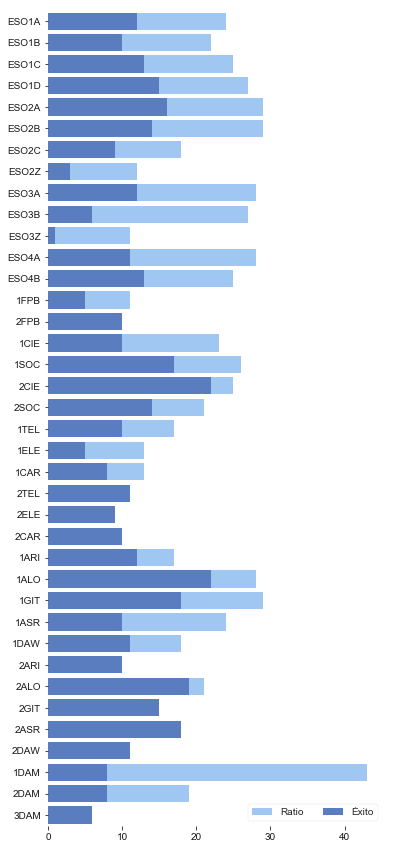

In [14]:
stacked_chart(dfc.reset_index(), "grupo", "ratio",
              "éxito_abs", "Ratio", "Éxito")

## ESO + FPB

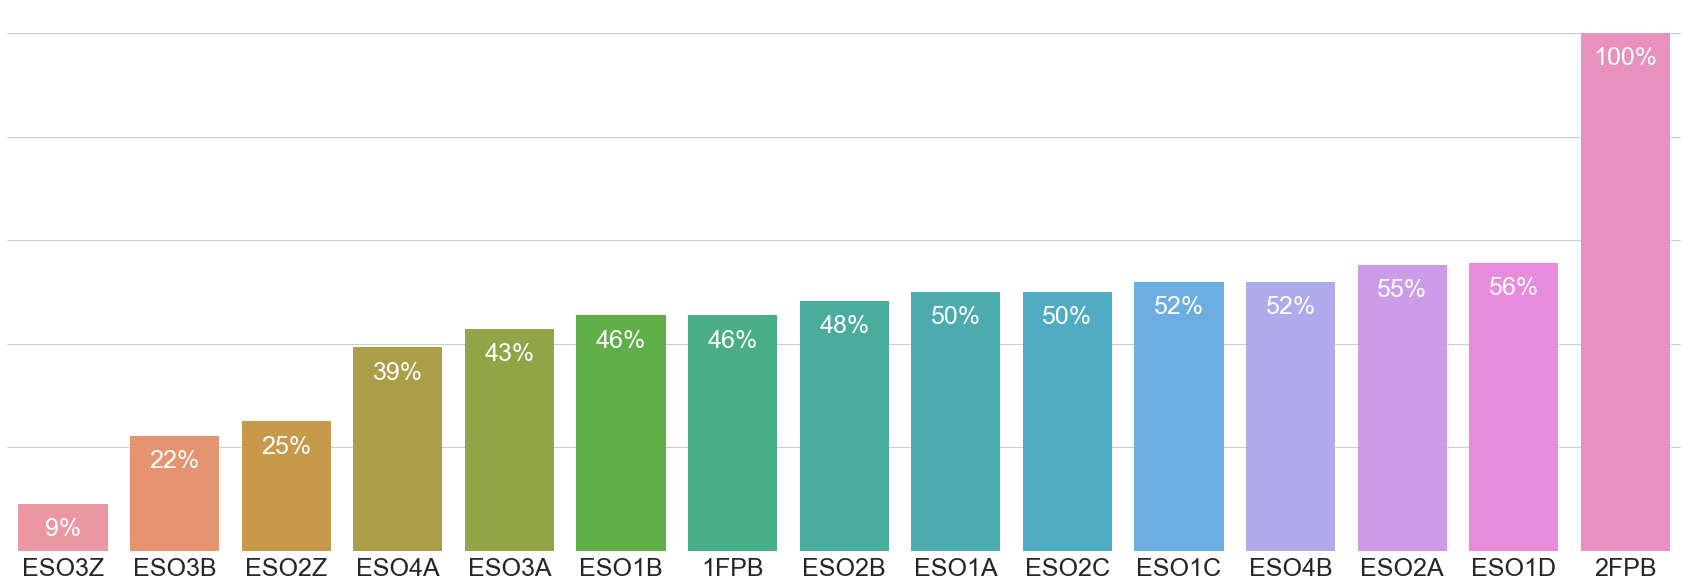

In [15]:
df_ESOFPB = get_data_by_stages(dfc, ["ESO", "FPB"])
bar_chart(df_ESOFPB["éxito"])

In [16]:
df_ESOFPB.mean()

éxito                       46.173333
absentismo_justificado       2.694000
absentismo_injustificado     7.642000
partes                       1.866667
suspensión_asistencia        0.533333
ratio                       21.733333
absentismo                  10.336000
éxito_abs                   10.000000
dtype: float64

## BACHILLERATO

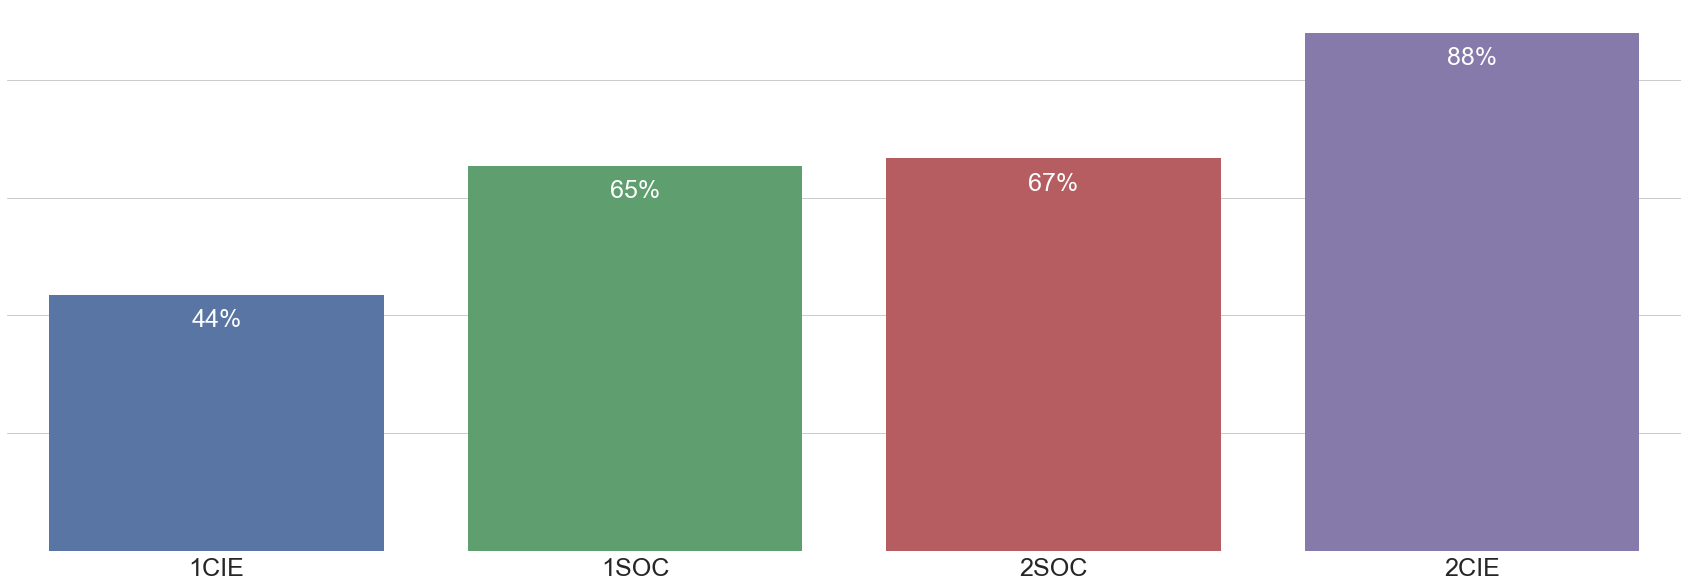

In [17]:
df_BACH = get_data_by_stages(dfc, "BACH")
bar_chart(df_BACH["éxito"])

In [18]:
df_BACH.mean()

éxito                       65.900
absentismo_justificado       2.625
absentismo_injustificado     3.190
partes                       0.000
suspensión_asistencia        0.000
ratio                       23.750
absentismo                   5.815
éxito_abs                   15.750
dtype: float64

## CICLOS FORMATIVOS DE GRADO MEDIO

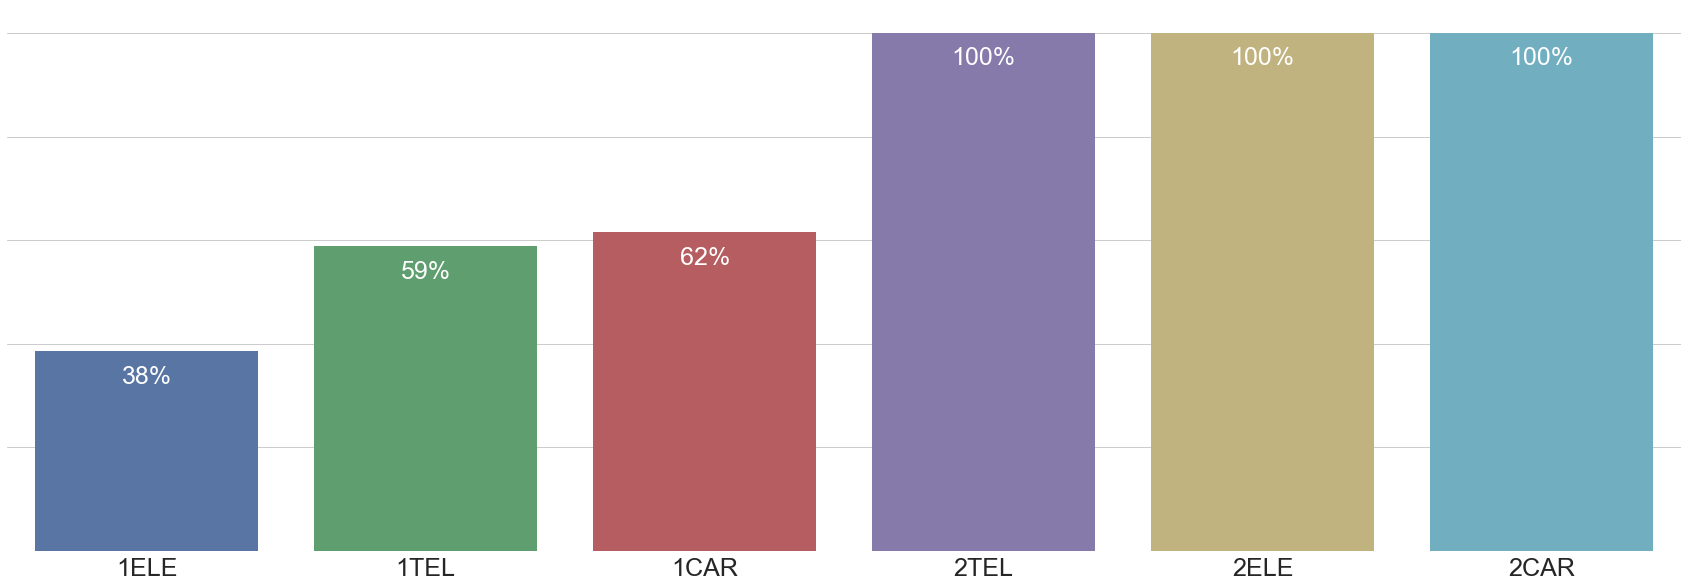

In [19]:
df_CFGM = get_data_by_stages(dfc, "CFGM")
bar_chart(df_CFGM["éxito"])

In [20]:
df_CFGM.mean()

éxito                       76.466667
absentismo_justificado       1.946667
absentismo_injustificado    13.333333
partes                       0.333333
suspensión_asistencia        0.000000
ratio                       12.166667
absentismo                  15.280000
éxito_abs                    8.833333
dtype: float64

## CICLOS FORMATIVOS DE GRADO SUPERIOR

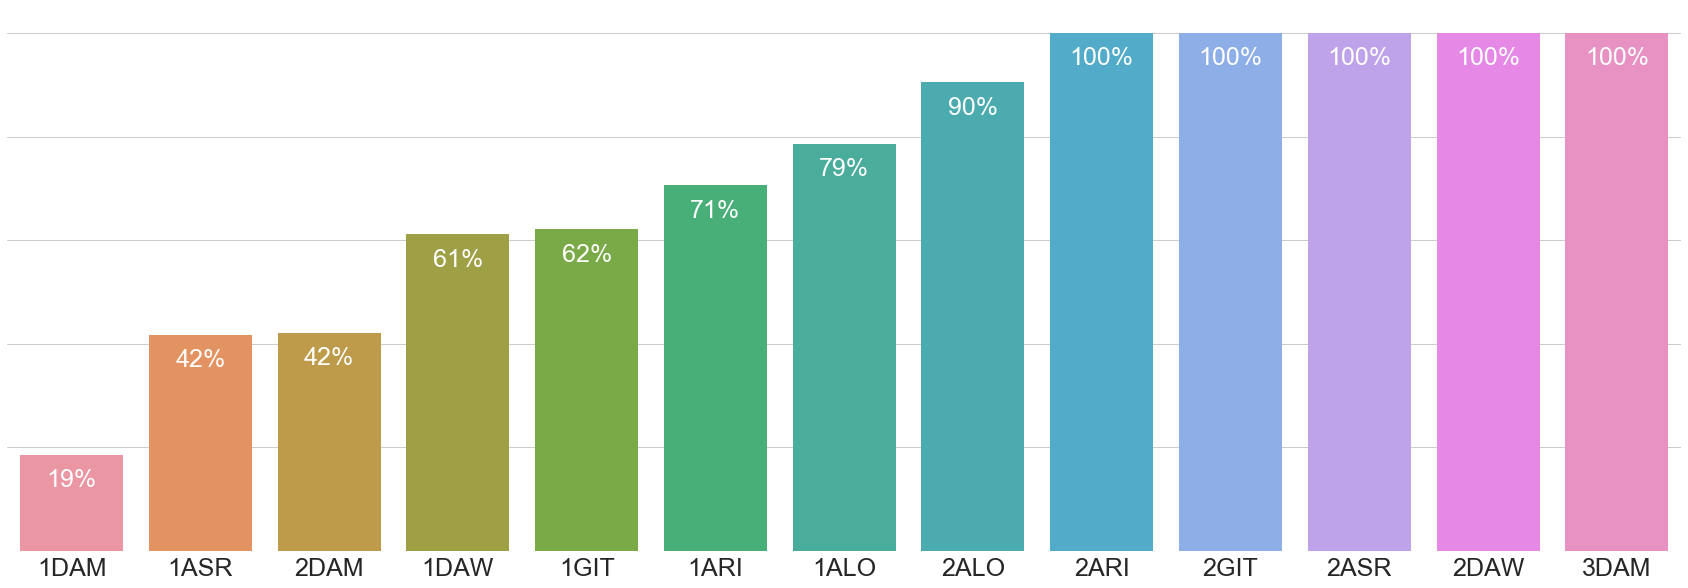

In [21]:
df_CFGS = get_data_by_stages(dfc, "CFGS")
bar_chart(df_CFGS["éxito"])

In [22]:
df_CFGS.mean()

éxito                       74.253846
absentismo_justificado       1.654615
absentismo_injustificado     7.979231
partes                       0.000000
suspensión_asistencia        0.000000
ratio                       19.923077
absentismo                   9.633846
éxito_abs                   12.923077
dtype: float64

## GLOBAL

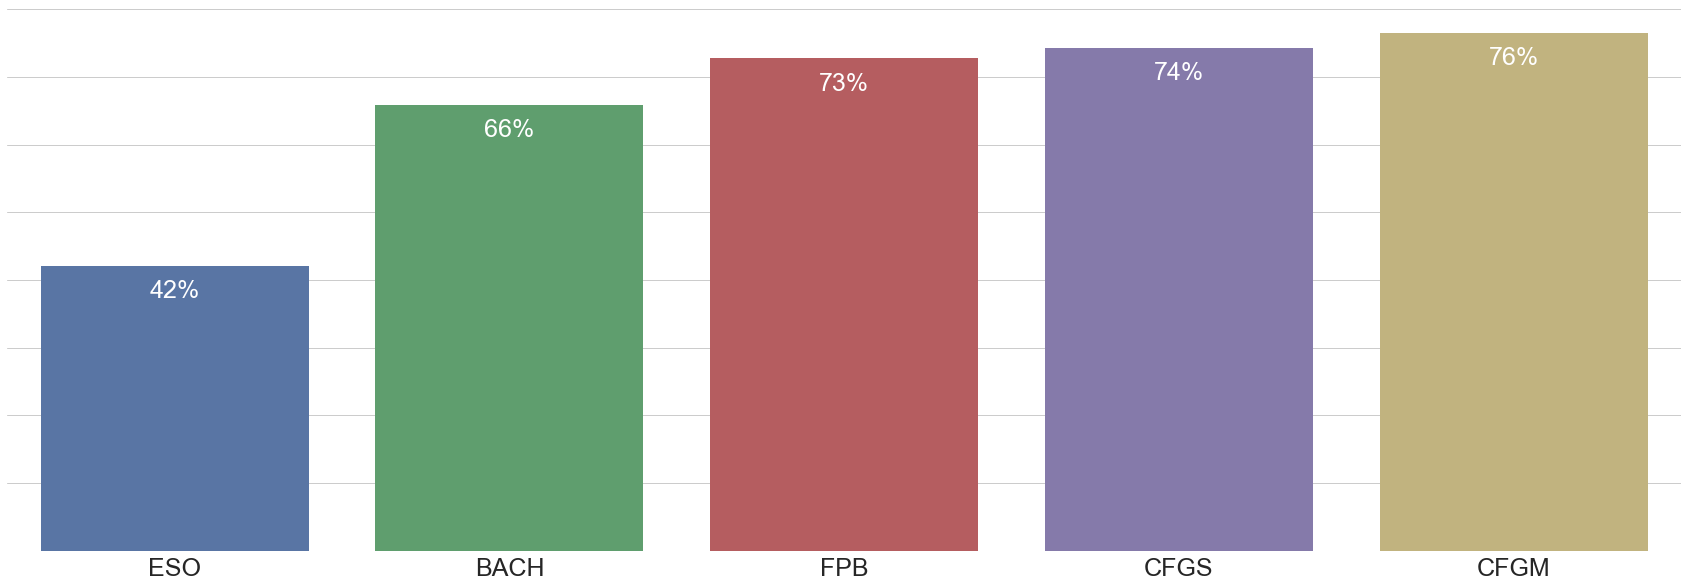

In [23]:
df_summary = dfc.groupby("etapa").mean()
bar_chart(df_summary["éxito"])

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

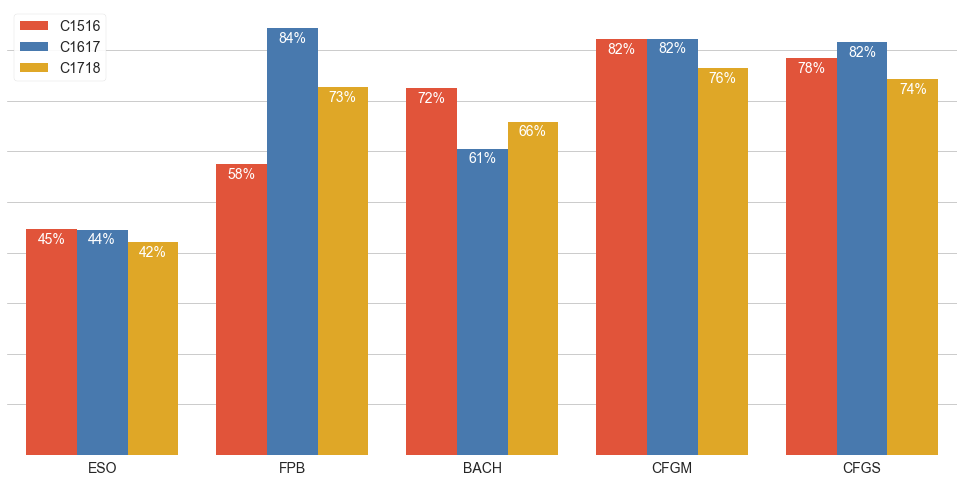

In [24]:
factor_chart(df.xs(labels[-1][1], level=1), "éxito")

In [25]:
mean_success = dfc["éxito"].mean()
display(HTML(f"""
<div class='alert alert-info' role='alert'>
    Éxito global medio: <b>{mean_success:.2f}</b>%
</div>
"""))

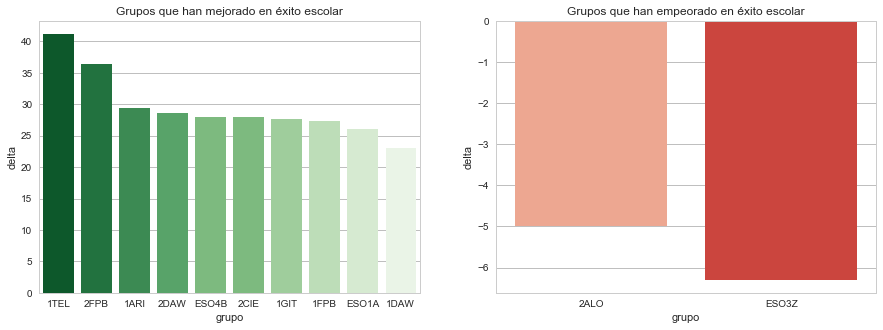

In [26]:
if EVALUATION > 1:
    display(HTML("<h2>EVOLUCIÓN DE GRUPOS CON RESPECTO A LA EVALUACIÓN ANTERIOR</h2>"))
    df_comp["delta"] = df_comp["éxito_x"] - df_comp["éxito_y"]
    df_comp = df_comp.sort_values("delta", ascending=False)
    delta_chart(df_comp[df_comp["delta"] > 0].head(10),
                df_comp[df_comp["delta"] < 0].head(10),
                label="éxito escolar")

## COMPETENCIAS BÁSICAS

**CL**: Comunicación lingüística.  
**CMCT**: Competencia matemática y competencias básicas en ciencia y tecnología.  
**CD**: Competencia digital.  
**AAP**: Aprender a aprender.  
**CSC**: Competencias sociales y cívicas.  
**SIEE**: Sentido de iniciativa y espíritu emprendedor.  
**CEC**: Conciencia y expresiones culturales.

#### Valor resumen por competencia básica:
\begin{equation}
MARCA = 0.025 * \mathbb{PA} + 0.050 * \mathbb{AD} + 0.075 * \mathbb{MA} + 0.1 * \mathbb{EX}
\end{equation}

, donde $\mathbb{PA}$, $\mathbb{AD}$, $\mathbb{MA}$ y $\mathbb{EX}$ son los porcentajes de adquisición de la competencia básica en cuestión.

In [27]:
COMPETENCE_CRITERIA = {
    "PA-%": "PA",
    "AD-%": "AD",
    "MA-%": "MA",
    "EX-%": "EX"
}

STUDIES = {
    "1º Educación Secundaria Obligatoria (LOMCE)": "1ESO",
    "2º Educación Secundaria Obligatoria (LOMCE)": "2ESO",
    "3º Educación Secundaria Obligatoria (LOMCE)": "3ESO",
    "4º Educación Secundaria Obligatoria (LOMCE)": "4ESO",
    "Primer curso del Programa de Mejora del Aprendizaje y el Rendimiento (LOMCE)": "1PMAR",
    "Segundo curso del Programa de Mejora del Aprendizaje y el Rendimiento (LOMCE)": "2PMAR"
}

COMPETENCE_ITEMS = {
    "Comunicación lingüística": "CL",
    "Competencia matemática y competencias básicas en ciencia y tecnología": "CMCT",
    "Competencia digital": "CD",
    "Aprender a aprender": "AAP",
    "Competencias sociales y cívicas": "CSC",
    "Sentido de iniciativa y espíritu emprendedor": "SIEE",
    "Conciencia y expresiones culturales": "CEC"
}

COMPETENCE_WEIGHTS = {
    "PA": 0.025,
    "AD": 0.050,
    "MA": 0.075,
    "EX": 0.1
}

# dataframe of basic competences
filename = "{}_ESO_CCBB.csv".format("".join(labels[-1]))
df_bc = pd.read_csv(os.path.join("../data/ccbb", filename),
                    encoding="cp1252", sep=";", skipfooter=9, engine="python")

df_bc = df_bc[df_bc["GRUPO"] != "TOTAL ESTUDIO"]

df_bc = df_bc.rename(columns=COMPETENCE_CRITERIA)
df_bc = df_bc[["ESTUDIO", "GRUPO", "ITEM", *COMPETENCE_CRITERIA.values()]]
df_bc["ESTUDIO"].replace(STUDIES, inplace=True)
df_bc["ITEM"].replace(COMPETENCE_ITEMS, inplace=True)

# summary value for each group-item
df_bc["MARCA"] = COMPETENCE_WEIGHTS["PA"] * df_bc["PA"] + \
                 COMPETENCE_WEIGHTS["AD"] * df_bc["AD"] + \
                 COMPETENCE_WEIGHTS["MA"] * df_bc["MA"] + \
                 COMPETENCE_WEIGHTS["EX"] * df_bc["EX"]

# grouped by groups
df_bc_grouped = df_bc.groupby("GRUPO").mean()["MARCA"]
index_with_right_order = dfc.index
dfc = pd.merge(dfc, pd.DataFrame(df_bc_grouped), left_index=True,
             right_index=True, how="outer", sort=False).rename(columns={"MARCA": "ccbb"})
dfc.index.name = "grupo"
dfc = dfc.loc[index_with_right_order]

dfc.head()

,etapa,éxito,absentismo_justificado,absentismo_injustificado,partes,suspensión_asistencia,ratio,absentismo,éxito_abs,ccbb
grupo,,,,,,,,,,
ESO1A,ESO,50.0,2.36,5.61,2.0,1.0,24.0,7.97,12.0,4.964286
ESO1B,ESO,45.5,2.54,2.67,1.0,0.0,22.0,5.21,10.0,5.146429
ESO1C,ESO,52.0,1.57,5.35,2.0,0.0,25.0,6.92,13.0,5.671429
ESO1D,ESO,55.6,1.27,4.20,3.0,2.0,27.0,5.47,15.0,5.132143
ESO2A,ESO,55.2,3.19,4.86,2.0,1.0,29.0,8.05,16.0,4.900000


### ESTUDIO POR NIVELES

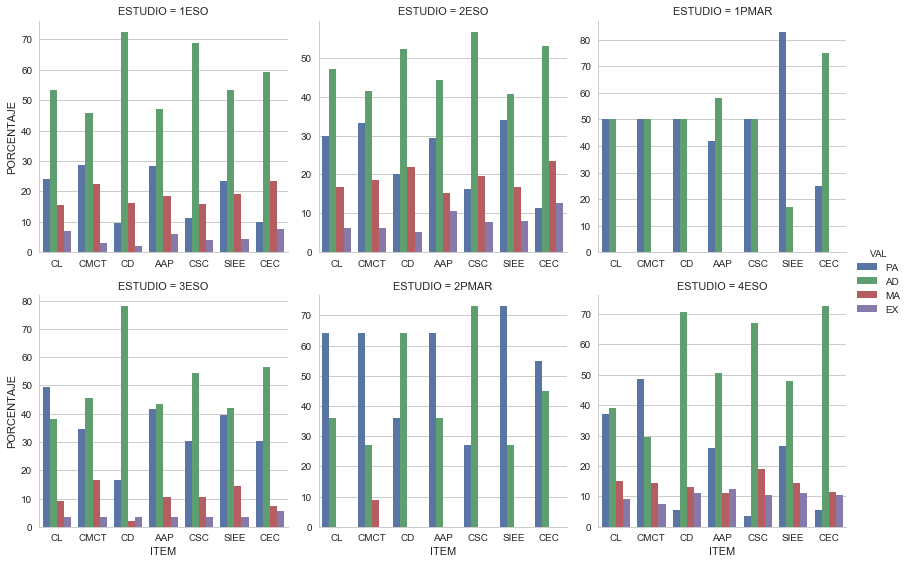

In [28]:
df_bc_melted = pd.melt(df_bc, ["ESTUDIO", "GRUPO", "ITEM"], [
                       "PA", "AD", "MA", "EX"], var_name="VAL", value_name="PORCENTAJE")
sns.factorplot(x="ITEM", y="PORCENTAJE", hue="VAL", col="ESTUDIO",
               data=df_bc_melted, col_wrap=3, kind="bar", sharex=False, sharey=False, ci=None)

## Análisis simplificado por competencias básicas

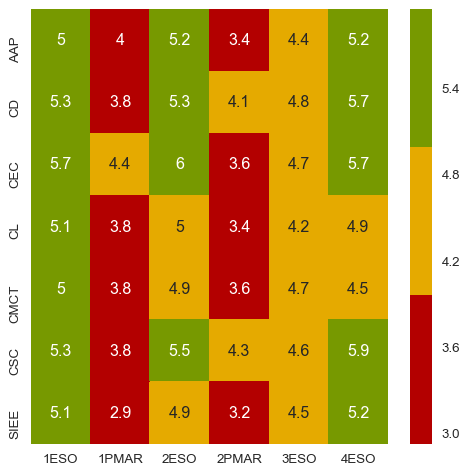

In [29]:
cdict = {
    "red":   ((0.0, 1.0, 0.7),
              (0.5, 1.0, 0.7),
              (1.0, 0.0, 0.0)),
    "green": ((0.0, 0.0, 0.0),
              (0.5, 1.0, 0.4),
              (1.0, 1.0, 0.4)),
    "blue":  ((0.0, 0.0, 0.0),
              (1.0, 0.0, 0.0))
}
from matplotlib.colors import LinearSegmentedColormap

z = df_bc.groupby([df_bc["ESTUDIO"], df_bc["ITEM"]]).mean().reset_index().pivot("ITEM", "ESTUDIO", "MARCA")
plt.figure(figsize=(6, 6), dpi=96)
cmap = LinearSegmentedColormap("custom_cmap", cdict, 4)
sns.heatmap(z, annot=True, cmap=cmap, center=5)
# hide axis labels
plt.xlabel("")
plt.ylabel("")
# hide ticks
plt.tick_params(top="off", bottom="off", left="off",
                right="off", labelleft="on", labelbottom="on")

### Nivel competencial resumen por estudios

In [30]:
df_bc["MARCA"].groupby(df_bc["ESTUDIO"]).mean().sort_values(ascending=False)

ESTUDIO
4ESO     5.321429
2ESO     5.250000
1ESO     5.228571
3ESO     4.557143
1PMAR    3.750000
2PMAR    3.664286
Name: MARCA, dtype: float64

### Nivel competencial resumen por competencias básicas

In [31]:
df_bc["MARCA"].groupby(df_bc["ITEM"]).mean().sort_values(ascending=False)

ITEM
CEC     5.346154
CSC     5.138462
CD      5.075000
AAP     4.788462
SIEE    4.686538
CL      4.673077
CMCT    4.665385
Name: MARCA, dtype: float64

### Máximo nivel competencial

In [32]:
df_bc.loc[df_bc["MARCA"].idxmax()][["GRUPO", "ITEM", "MARCA"]]

GRUPO    ESO2C
ITEM       CEC
MARCA      6.6
Name: 55, dtype: object

### Mínimo nivel competencial

In [33]:
df_bc.loc[df_bc["MARCA"].idxmin()][["GRUPO", "ITEM", "MARCA"]]

GRUPO    ESO2Z
ITEM      SIEE
MARCA    2.925
Name: 68, dtype: object

# ABSENTISMO

<div class="alert alert-success" role="alert">
    ABSENTISMO = **Faltas justificadas + Faltas injustificadas**
</div>

**Se va a estudiar el ABSENTISMO ACUMULADO desde el 1 de septiembre hasta la fecha de finalización del trimestre de análisis.**

## ABSENTISMO TOTAL vs ABSENTISMO JUSTIFICADO

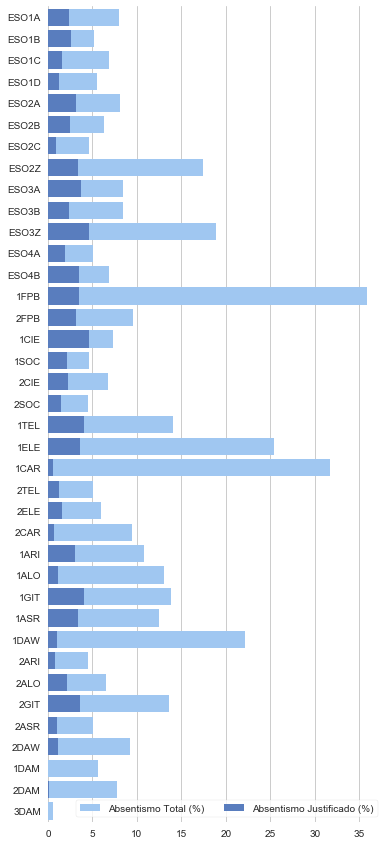

In [34]:
stacked_chart(dfc.reset_index(), "grupo", "absentismo",
              "absentismo_justificado", "Absentismo Total (%)", "Absentismo Justificado (%)")

## ESO + FPB

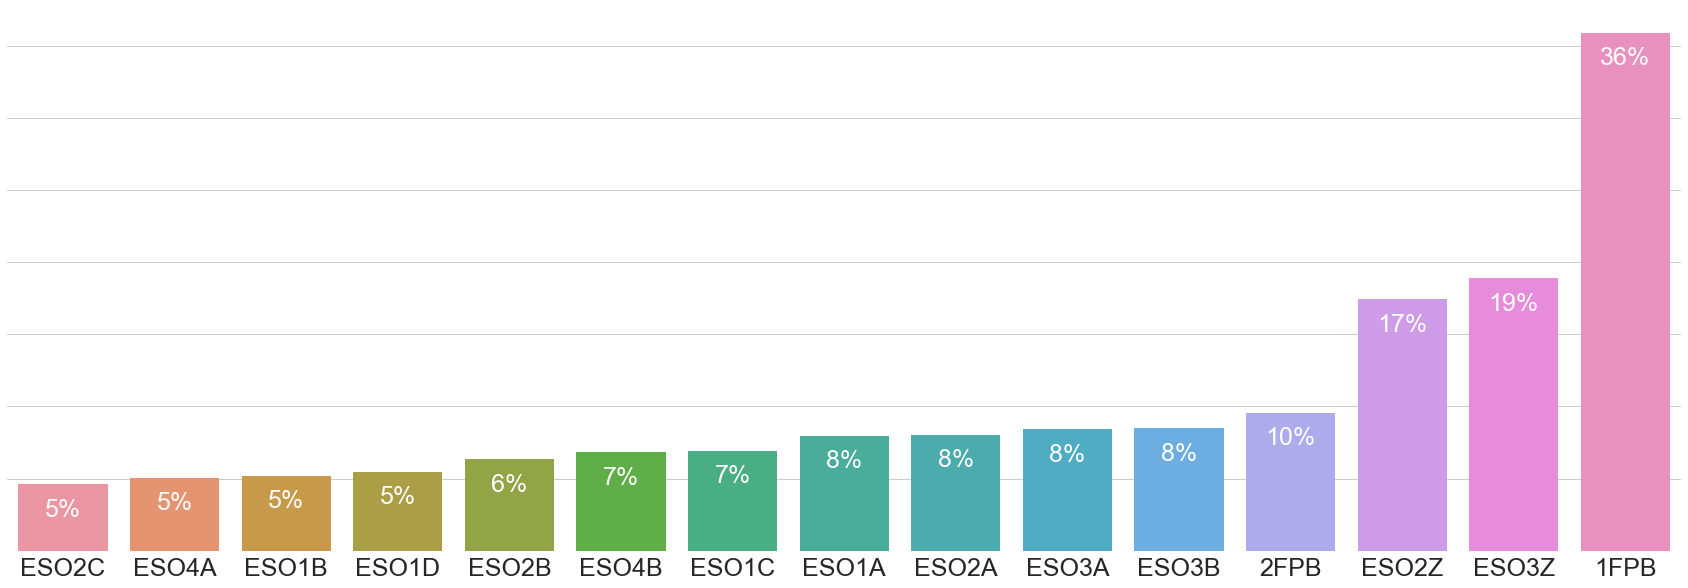

In [35]:
bar_chart(df_ESOFPB["absentismo"])

## BACHILLERATO

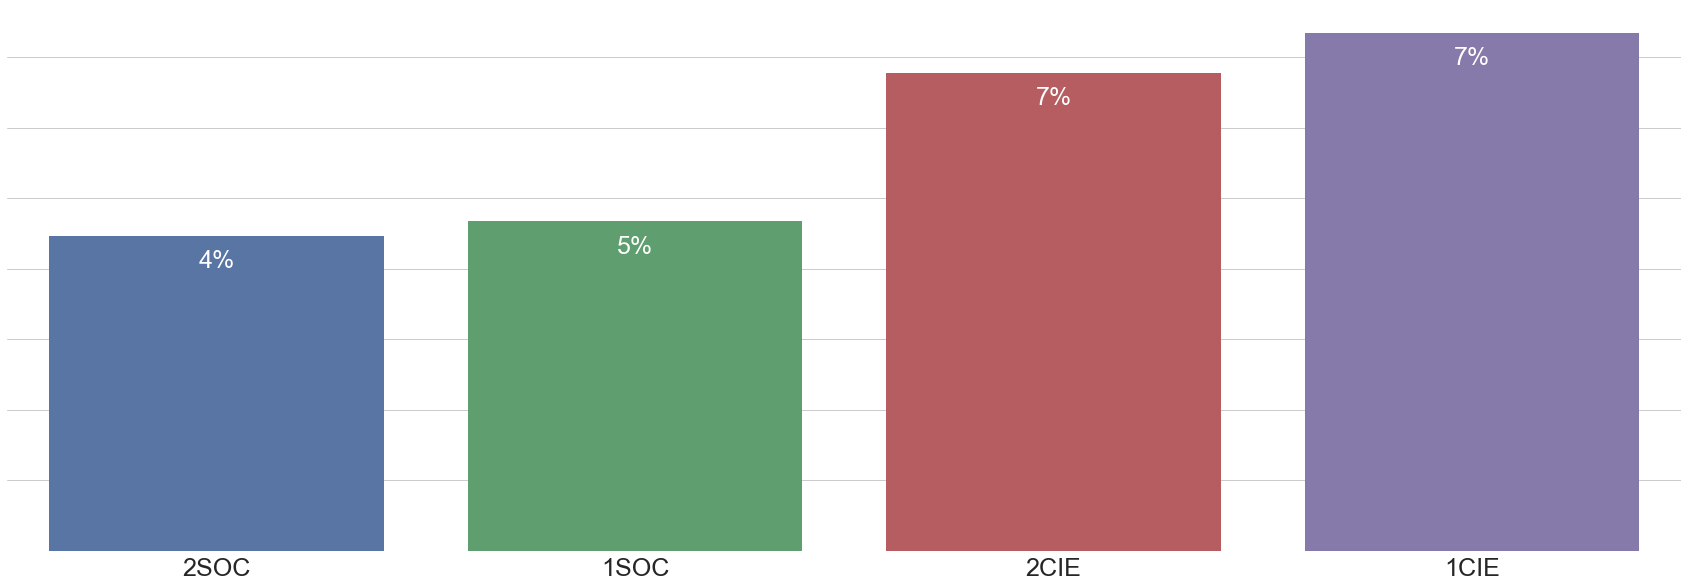

In [36]:
bar_chart(df_BACH["absentismo"])

## CICLOS FORMATIVOS DE GRADO MEDIO

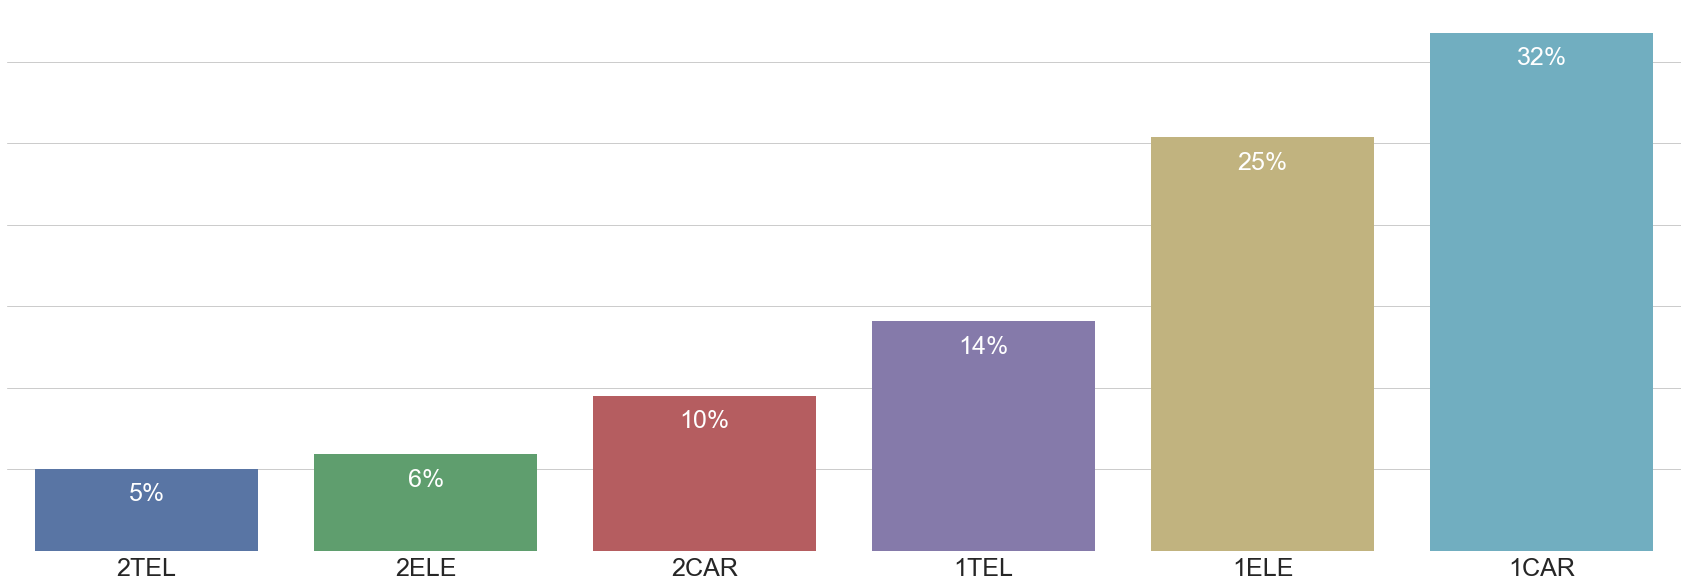

In [37]:
bar_chart(df_CFGM["absentismo"])

## CICLOS FORMATIVOS DE GRADO SUPERIOR

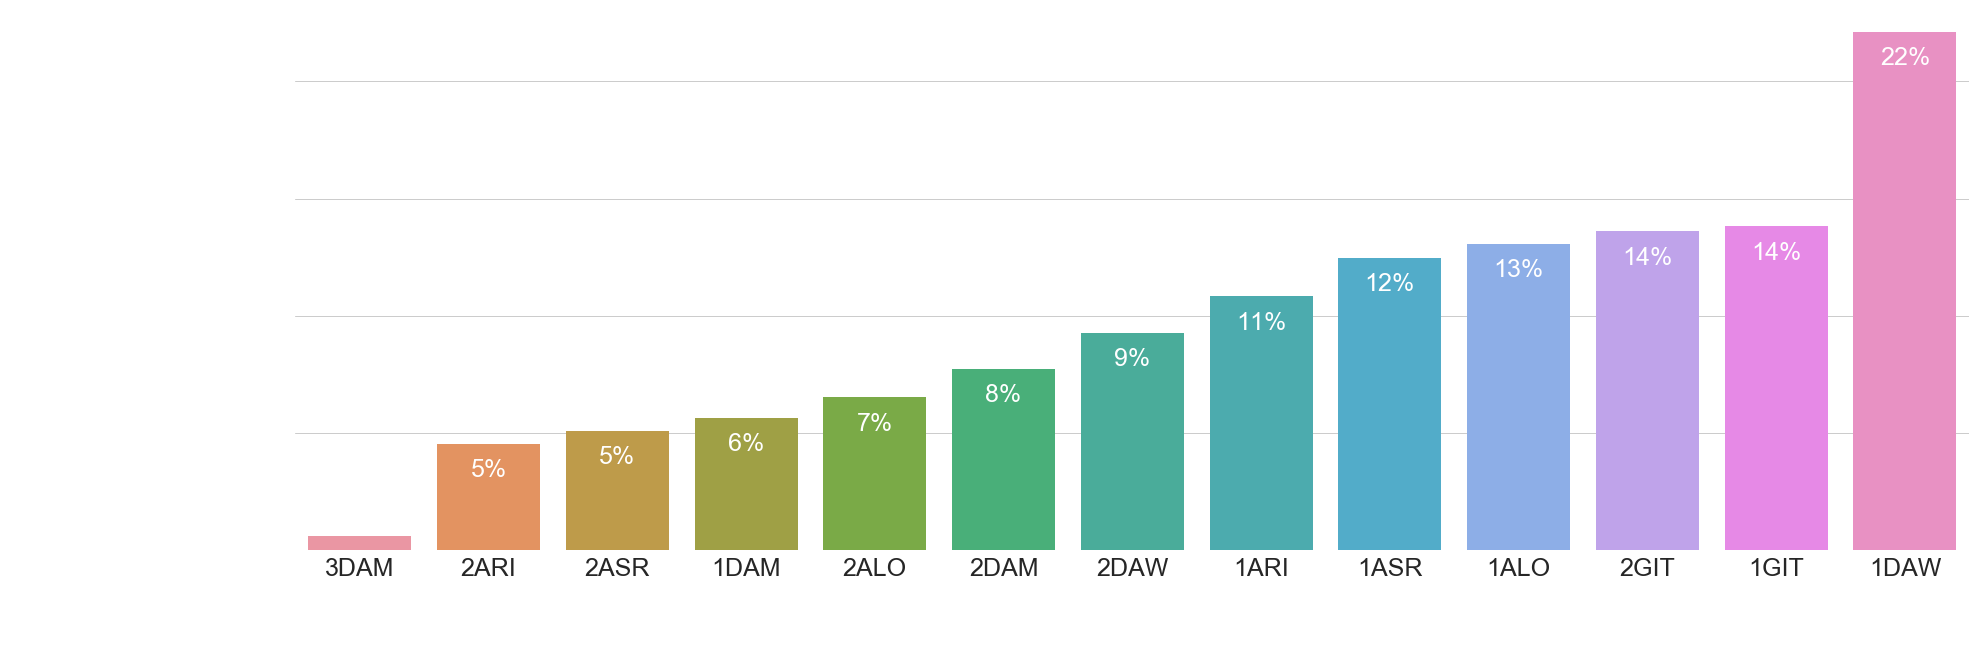

In [38]:
bar_chart(df_CFGS["absentismo"])

## GLOBAL

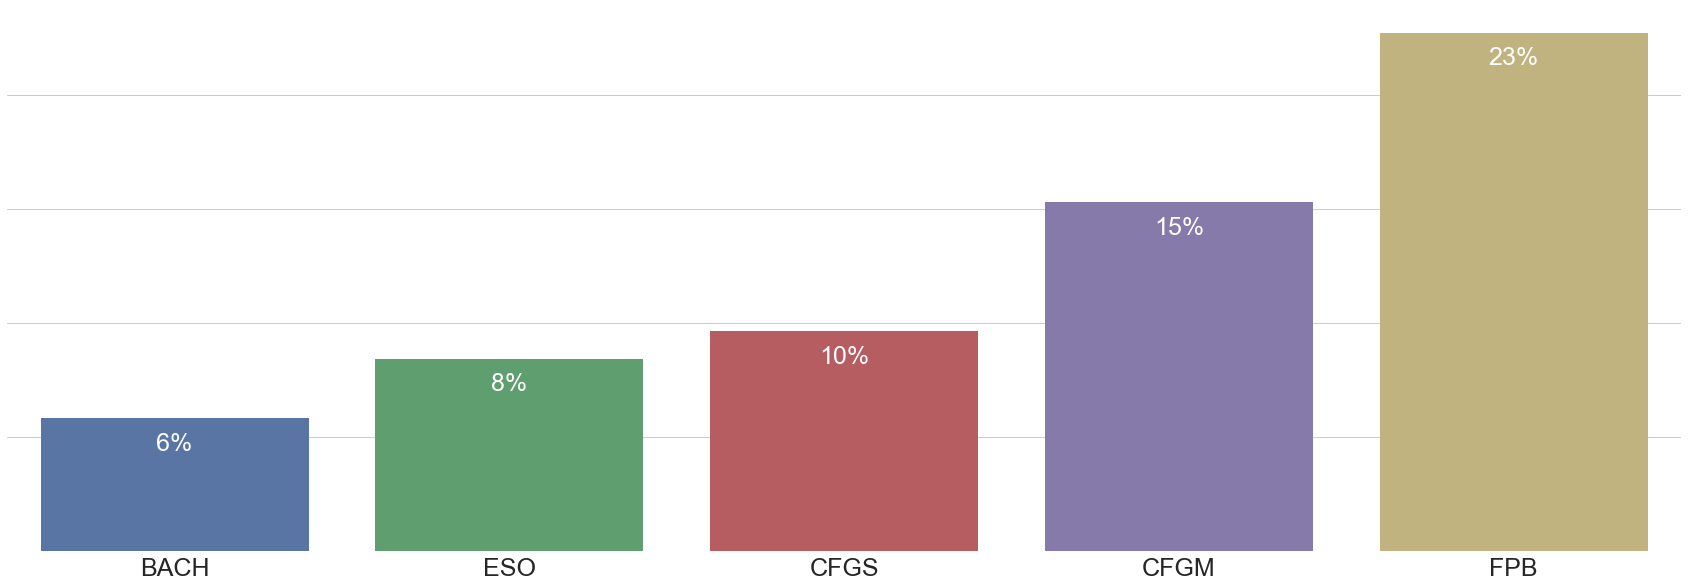

In [39]:
bar_chart(df_summary["absentismo"])

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

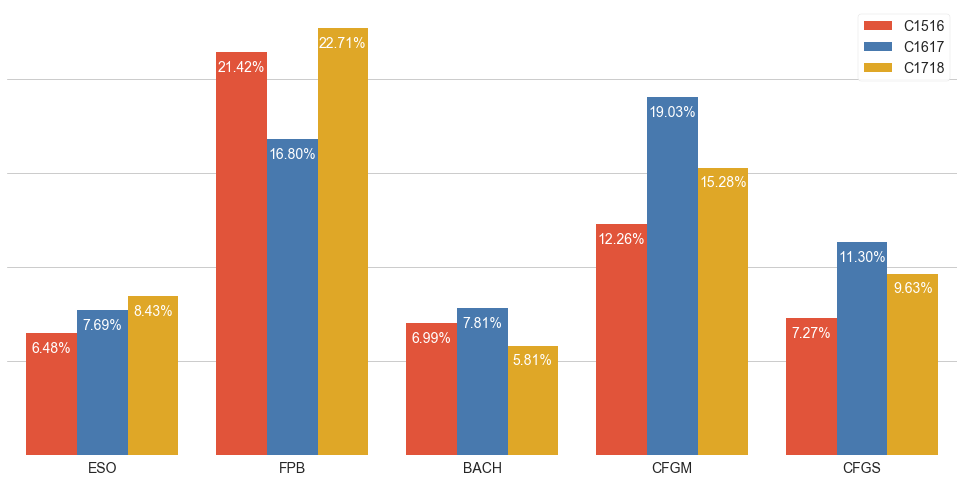

In [67]:
factor_chart(df.xs(labels[-1][1], level=1), "absentismo", .8, show_integer=False)

In [41]:
mean_absence = dfc["absentismo"].mean()
display(HTML(f"""
<div class='alert alert-info' role='alert'>
    Absentismo global medio: <b>{mean_absence:.2f}</b>%
</div>
"""))

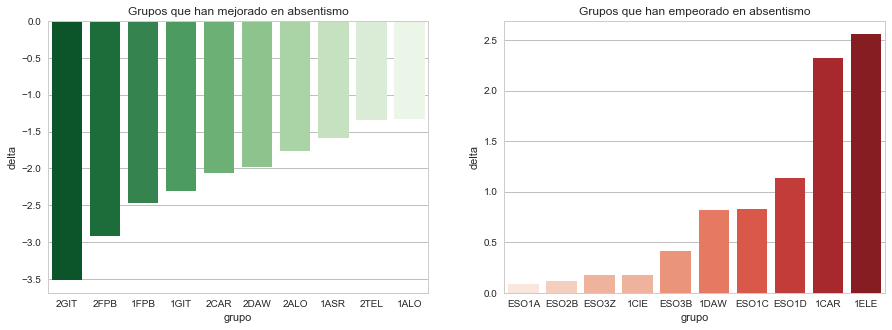

In [42]:
if EVALUATION > 1:
    display(HTML("<h2>EVOLUCIÓN DE GRUPOS CON RESPECTO A LA EVALUACIÓN ANTERIOR"))
    df_comp["delta"] = df_comp["absentismo_x"] - df_comp["absentismo_y"]
    df_comp = df_comp.sort_values("delta")
    delta_chart(df_comp[df_comp["delta"] < 0].head(10),
                df_comp[df_comp["delta"] > 0].head(10),
                label="absentismo", inverse=True)

# GESTIÓN DE LA CONVIVENCIA

## PARTES DE GESTIÓN

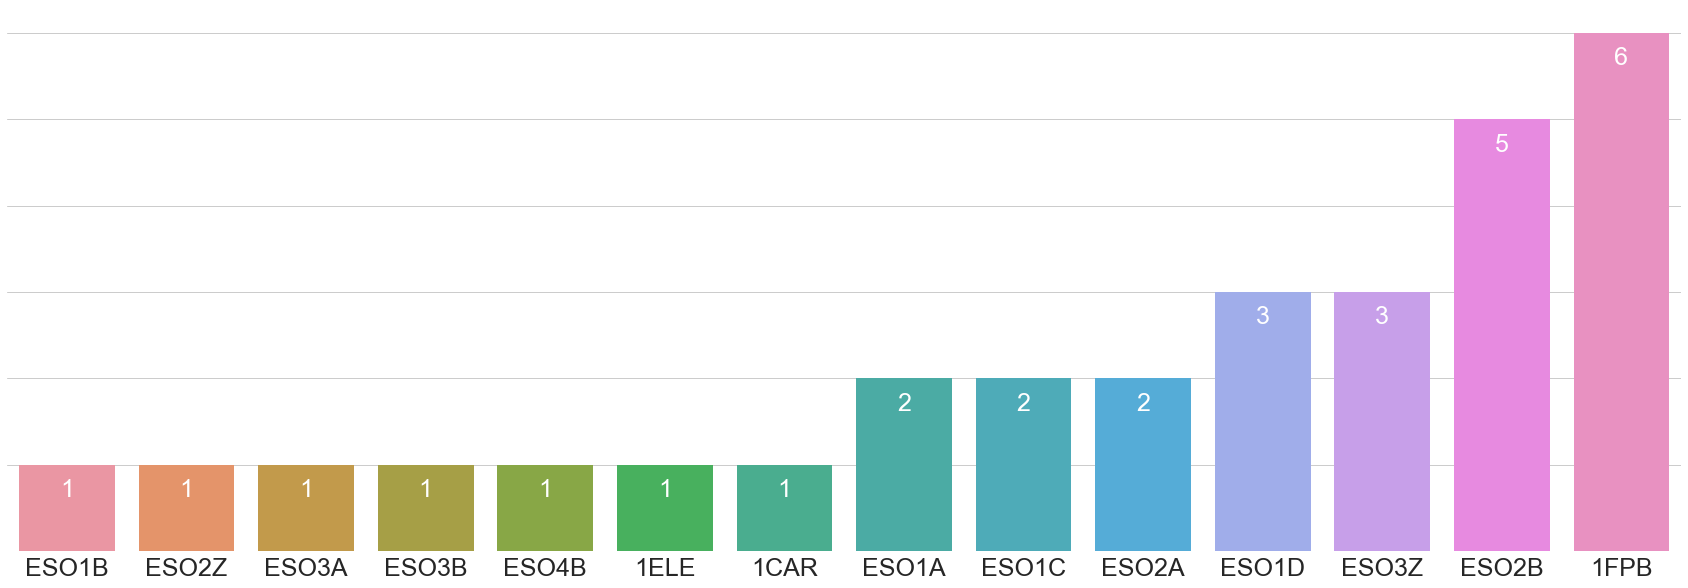

In [43]:
df_reports = dfc[dfc["partes"] > 0]["partes"]
bar_chart(df_reports, False)

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

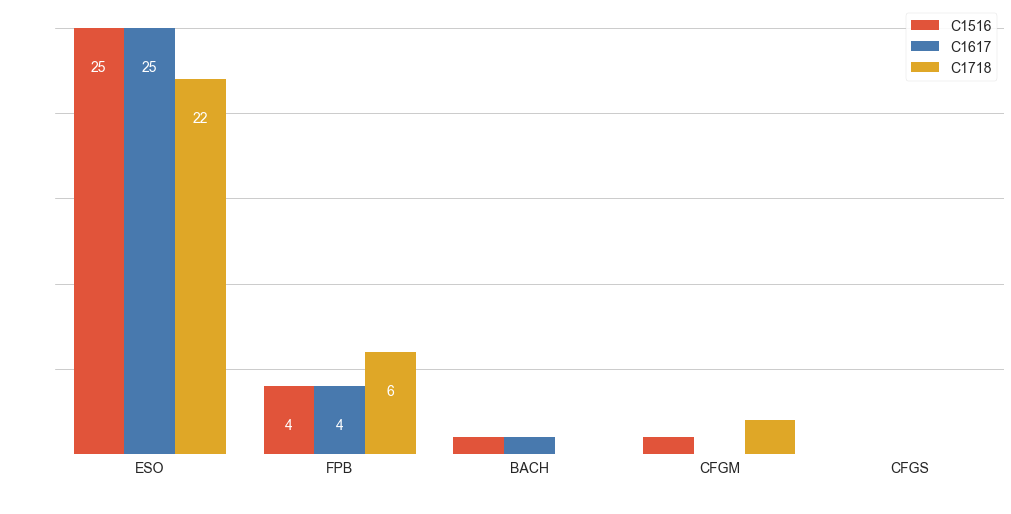

In [44]:
factor_chart(df.xs(labels[-1][1], level=1), "partes", 2.3, False, np.sum)

In [45]:
total_reports = df_reports.sum()
display(HTML(f"""
<div class='alert alert-info' role='alert'>
    Total de partes de gestión: <b>{total_reports:.0f}</b>
</div>
"""))

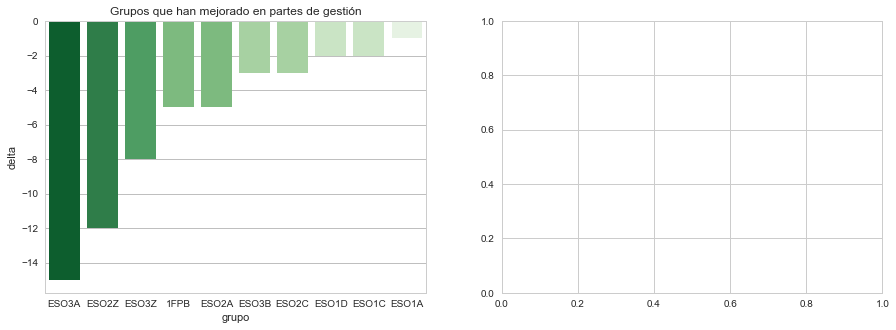

In [46]:
if EVALUATION > 1:
    display(HTML("<h2>EVOLUCIÓN DE GRUPOS CON RESPECTO A LA EVALUACIÓN ANTERIOR"))
    df_comp["delta"] = df_comp["partes_x"] - df_comp["partes_y"]
    df_comp = df_comp.sort_values("delta")
    delta_chart(df_comp[df_comp["delta"] < 0].head(10),
                df_comp[df_comp["delta"] > 0].head(10),
                label="partes de gestión", inverse=True)

## SUSPENSIÓN DEL DERECHO DE ASISTENCIA

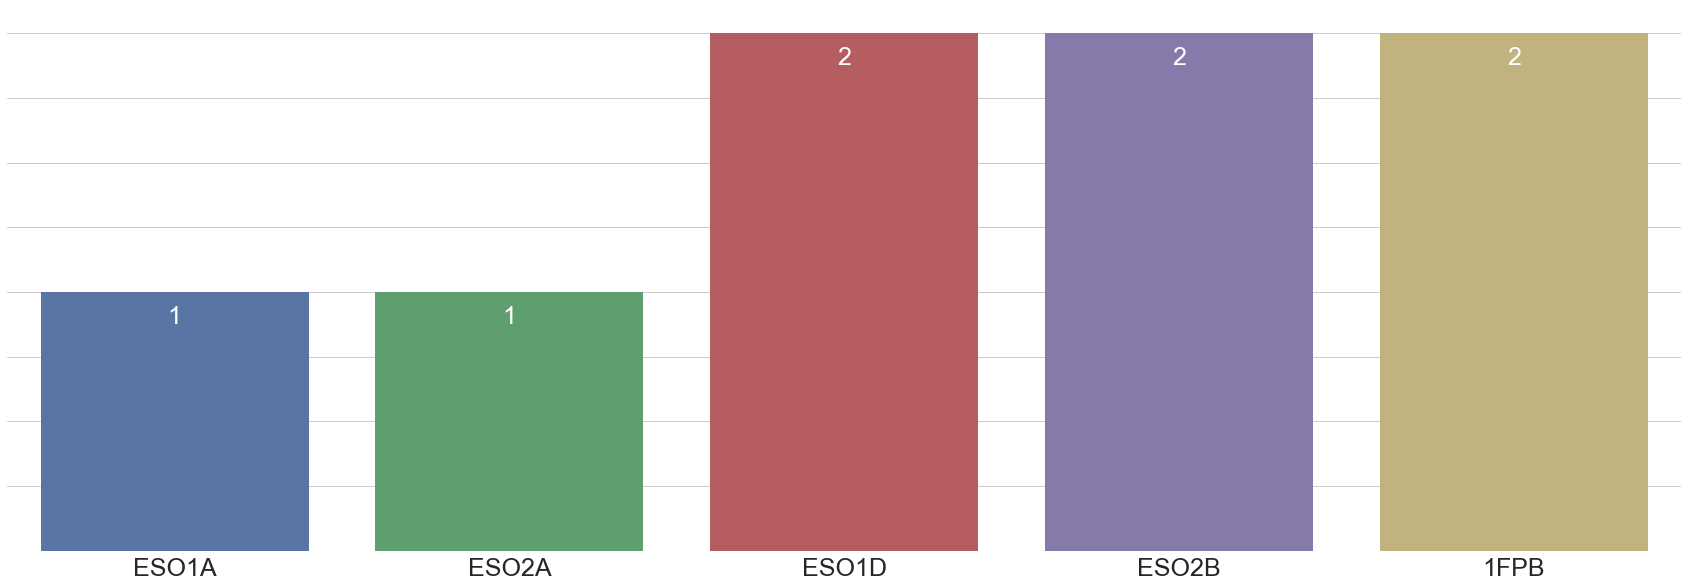

In [47]:
df_non_attendance = dfc[dfc["suspensión_asistencia"] > 0]["suspensión_asistencia"]
bar_chart(df_non_attendance, False)

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

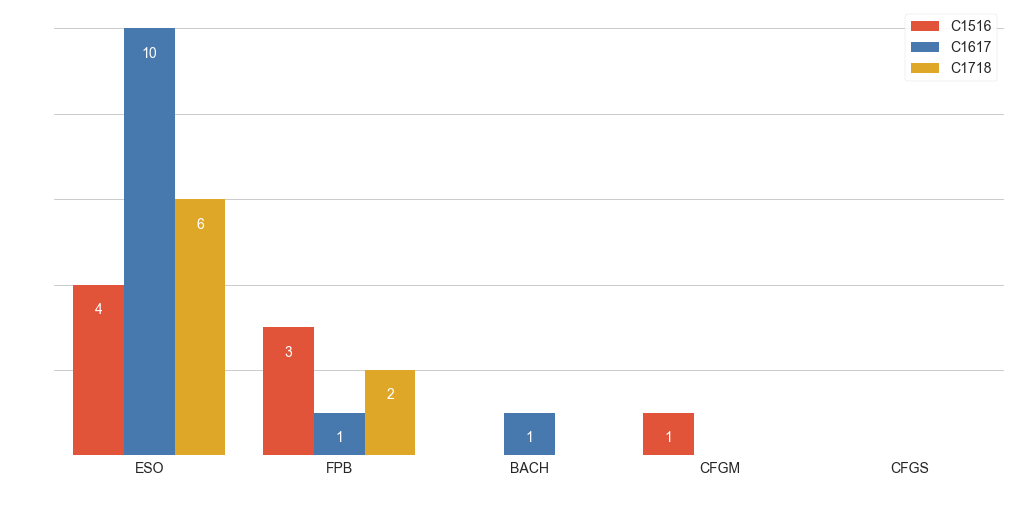

In [48]:
factor_chart(df.xs(labels[-1][1], level=1),
             "suspensión_asistencia", .6, False, np.sum)

In [49]:
total_non_attendance = df_non_attendance.sum()
display(HTML(f"""
<div class='alert alert-info' role='alert'>
    Total de partes de gestión con <b>suspensión</b> del derecho de asistencia: <b>{total_non_attendance:.0f}</b>
</div>
"""))

# RELACIÓN `éxito-competencias básicas`

> **NOTA**: Análisis únicamente con grupos de la ESO.

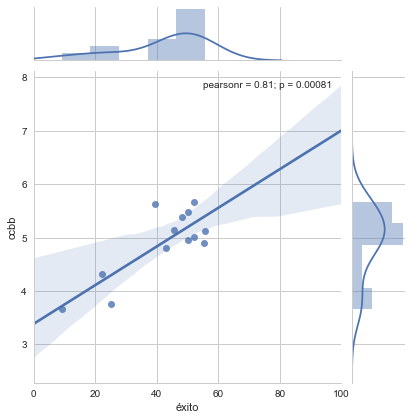

In [50]:
sns.jointplot("éxito", "ccbb", dfc, kind="reg", xlim=(0, 100));

## Detección de *outliers*

### Bajo éxito y alta adquisición de competencias básicas

In [51]:
dfc[(dfc["éxito"] < 20) & (dfc["ccbb"] > 5)][["éxito", "ccbb"]]

,éxito,ccbb
grupo,,


### Alto éxito y baja adquisición de competencias básicas

In [52]:
dfc[(dfc["éxito"] > 50) & (dfc["ccbb"] < 4)][["éxito", "ccbb"]]

,éxito,ccbb
grupo,,


# RELACIÓN `ratio-éxito`

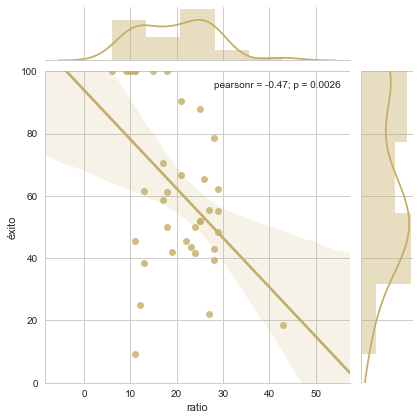

In [53]:
sns.jointplot("ratio", "éxito", dfc, kind="reg", ylim=(0, 100), color="y");

## Detección de *outliers*

### Baja ratio y bajo éxito

In [54]:
dfc[(dfc["ratio"] < 20) & (dfc["éxito"] < 20)][["ratio", "éxito"]]

,ratio,éxito
grupo,,
ESO3Z,11.0,9.1


### Alta ratio y alto éxito

In [55]:
dfc[(dfc["ratio"] > 25) & (dfc["éxito"] > 50)][["ratio", "éxito"]]

,ratio,éxito
grupo,,
ESO1D,27.0,55.6
ESO2A,29.0,55.2
1SOC,26.0,65.4
1ALO,28.0,78.6
1GIT,29.0,62.1


# RELACIÓN `absentismo-éxito`

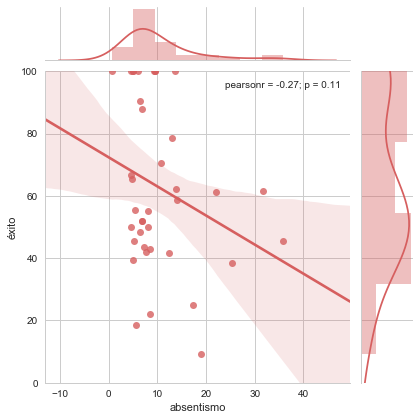

In [56]:
sns.jointplot("absentismo", "éxito", dfc, kind="reg", color="r", ylim=(0, 100));

## Detección de *outliers*

### Bajo absentismo y bajo éxito

In [57]:
dfc[(dfc["absentismo"] < 10) & (dfc["éxito"] < 10)][["absentismo", "éxito"]]

,absentismo,éxito
grupo,,


### Alto absentismo y alto éxito

In [58]:
dfc[(dfc["absentismo"] > 25) & (dfc["éxito"] > 50)][["absentismo", "éxito"]]

,absentismo,éxito
grupo,,
1CAR,31.76,61.5


# RELACIÓN `partes-éxito`

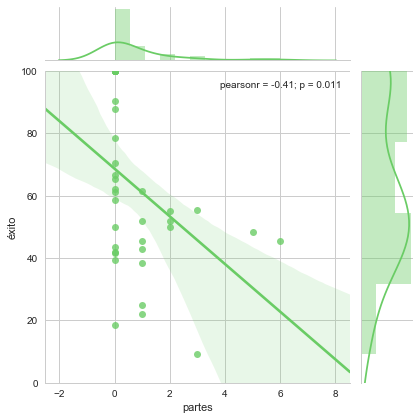

In [59]:
sns.jointplot("partes", "éxito", dfc, kind="reg", color="g", ylim=(0, 100));

## Detección de *outliers*

### Bajo número de partes y bajo éxito

In [60]:
dfc[(dfc["partes"] < 10) & (dfc["éxito"] < 10)][["partes", "éxito"]]

,partes,éxito
grupo,,
ESO3Z,3.0,9.1


### Alto número de partes y alto éxito

In [61]:
dfc[(dfc["partes"] > 15) & (dfc["éxito"] > 30)][["partes", "éxito"]]

,partes,éxito
grupo,,


# GRUPOS MÁGICOS

> Son aquellos que tienen mejores valores de éxito escolar, menor absentismo y menos partes de gestión.

\begin{equation}
magic = 0.6 · success + 0.2 · e^{-absence} + 0.2 · e^{-reports}
\end{equation}

In [62]:
df2 = dfc.copy()
df2["magic"] = 0.6 * df2["éxito"] + 0.2 * \
    np.exp(-df2["absentismo"]) + 0.2 * np.exp(-df2["partes"])
magic = df2.sort_values("magic", ascending=False)

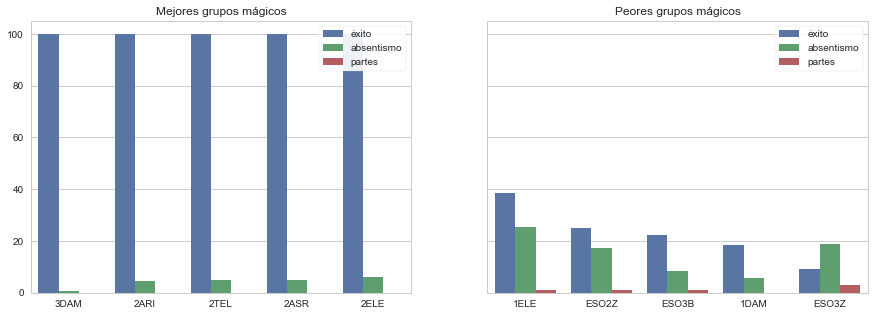

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

best_magic = pd.melt(magic.head(5).reset_index(), id_vars="grupo", value_vars=[
                     "éxito", "absentismo", "partes"])
g = sns.factorplot(x="grupo", y="value", hue="variable",
                   data=best_magic, kind="bar", ax=ax1)
ax1.set_title("Mejores grupos mágicos")
ax1.set(ylabel="", xlabel="")
ax1.legend(loc="best", frameon=True, framealpha=0.9)
plt.close(g.fig)

worse_magic = pd.melt(magic.tail(5).reset_index(), id_vars="grupo", value_vars=[
                      "éxito", "absentismo", "partes"])
g = sns.factorplot(x="grupo", y="value", hue="variable",
                   data=worse_magic, kind="bar", ax=ax2, legend_out=True)
ax2.set_title("Peores grupos mágicos")
ax2.set(ylabel="", xlabel="")
ax2.legend(loc="best", frameon=True, framealpha=0.9)
plt.close(g.fig)